
# GraphRAG Parquet → Graph Visualization (NetworkX + PyVis)

This notebook loads GraphRAG parquet outputs (entities, relationships, communities, etc.), builds a graph, and visualizes it:

**What you'll get**
- Node/edge counts and quick sanity checks
- A NetworkX graph from `entities.parquet` + `relationships.parquet`
- Static matplotlib drawing for a filtered subgraph
- An interactive HTML graph via **PyVis** (easy to explore/zoom/drag)
- Optional: export CSVs for Neo4j import (if you want to explore in Neo4j)

> Tip: If graph is large, start with a small `TOP_N_NODES` or a higher `MIN_EDGE_WEIGHT` to keep drawings fast.


In [1]:

# --- Config ---
OUTPUT_DIR = "./output"        # path to GraphRAG output dir
VIZ_DIR = f"{OUTPUT_DIR}/_viz"           # where to save visualizations
MIN_EDGE_WEIGHT = 0.0                    # filter out weak edges (>= this weight)
TOP_N_NODES = 150                        # build a subgraph with top-N nodes by degree for plotting (None for all)
SEED = 42


In [2]:

import os
from pathlib import Path
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Optional but nice: interactive HTML
try:
    from pyvis.network import Network
    HAS_PYVIS = True
except Exception:
    HAS_PYVIS = False

Path(VIZ_DIR).mkdir(parents=True, exist_ok=True)

entities_pq = Path(OUTPUT_DIR) / "entities.parquet"
rels_pq     = Path(OUTPUT_DIR) / "relationships.parquet"
comms_pq    = Path(OUTPUT_DIR) / "communities.parquet"
commrep_pq  = Path(OUTPUT_DIR) / "community_reports.parquet"

print("Exists:")
for p in [entities_pq, rels_pq, comms_pq, commrep_pq]:
    print(f"  {p}: {p.exists()}")


Exists:
  output\entities.parquet: True
  output\relationships.parquet: True
  output\communities.parquet: True
  output\community_reports.parquet: True


In [ ]:

# --- Load parquet files ---
import pyarrow

entities = pd.read_parquet(entities_pq) if entities_pq.exists() else pd.DataFrame()
rels = pd.read_parquet(rels_pq) if rels_pq.exists() else pd.DataFrame()
comms = pd.read_parquet(comms_pq) if comms_pq.exists() else pd.DataFrame()

print("entities columns:", list(entities.columns))
print("relationships columns:", list(rels.columns))
print("communities columns:", list(comms.columns))

print("\nCounts:")
print("  entities:", len(entities))
print("  relationships:", len(rels))
print("  communities:", len(comms))


entities columns: ['id', 'human_readable_id', 'title', 'type', 'description', 'text_unit_ids', 'frequency', 'degree', 'x', 'y']
relationships columns: ['id', 'human_readable_id', 'source', 'target', 'description', 'weight', 'combined_degree', 'text_unit_ids']
communities columns: ['id', 'human_readable_id', 'community', 'level', 'parent', 'children', 'title', 'entity_ids', 'relationship_ids', 'text_unit_ids', 'period', 'size']

Counts:
  entities: 8
  relationships: 7
  communities: 1



## Build a NetworkX graph

We'll assume the standard GraphRAG schema:
- `entities.parquet` has a unique `id` per entity, plus fields like `title`, `type` (person/org/geo/event), etc.
- `relationships.parquet` references two entities via columns like `source_id` and `target_id`, and commonly has a numeric `weight` and a `description`.
> If your column names differ, tweak the mapping below.


In [7]:
# --- choose consistent columns ---
ents = pd.read_parquet(Path(OUTPUT_DIR) / "entities.parquet")
rels = pd.read_parquet(Path(OUTPUT_DIR) / "relationships.parquet")
# 关系表端点列
SRC = next(c for c in ["source_id","source","src_id","head_id"] if c in rels.columns)
TGT = next(c for c in ["target_id","target","dst_id","tail_id"] if c in rels.columns)
W   = next((c for c in ["weight","edge_weight","strength"] if c in rels.columns), None)
LBL = next((c for c in ["description","relation","type","label"] if c in rels.columns), None)

# 实体表里用哪个“名字”当作节点键，尽量能匹配到 relationships 的 source/target
ENT_KEY = next((c for c in ["title","name","human_readable_id","label"] if c in ents.columns), "id")

print(f"Using -> SRC:{SRC}, TGT:{TGT}, W:{W}, LBL:{LBL}, ENT_KEY:{ENT_KEY}")

# 做一下大小写统一，避免 'Scrooge' vs 'SCROOGE'
def norm(x):
    return str(x).strip().upper()

rels["_src_key"] = rels[SRC].map(norm)
rels["_tgt_key"] = rels[TGT].map(norm)

ents["_ent_key"] = ents[ENT_KEY].map(norm)

# 如果 ENT_KEY 不是唯一的，先去重（通常是唯一）
ents_unique = ents.drop_duplicates("_ent_key").copy()
key_set = set(ents_unique["_ent_key"])

# --- build graph ---
G = nx.Graph()

# 先按“统一后的名字”加节点，这样和边能对上
for _, row in ents_unique.iterrows():
    node_key = row["_ent_key"]
    attrs = row.drop(labels=["_ent_key"]).to_dict()
    G.add_node(node_key, **attrs)

missing_src = 0
missing_tgt = 0
added_edges = 0

for _, r in rels.iterrows():
    s = r["_src_key"]; t = r["_tgt_key"]
    if s not in key_set: missing_src += 1
    if t not in key_set: missing_tgt += 1
    # 即使缺失也先加，NetworkX 会自动补节点，但我们更希望都在实体表里
    data = {}
    if W is not None:   data["weight"] = float(r[W])
    if LBL is not None: data["label"]  = str(r[LBL])
    G.add_edge(s, t, **data)
    added_edges += 1

print(f"Graph built: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
print(f"Edges added={added_edges}, missing_src={missing_src}, missing_tgt={missing_tgt}")

# 如果你更想用实体 UUID 做节点键，也可以把 relationships 的 source/target 先 join 到实体表，改成 UUID 再建图。


Using -> SRC:source, TGT:target, W:weight, LBL:description, ENT_KEY:title
Graph built: Nodes=8, Edges=7
Edges added=7, missing_src=0, missing_tgt=0


In [4]:

# --- Column name mapping (adjust if your schema differs) ---
# Try to infer common names:
src_col_candidates = ["source_id", "source", "src_id", "head_id"]
tgt_col_candidates = ["target_id", "target", "dst_id", "tail_id"]
w_col_candidates   = ["weight", "edge_weight", "strength"]
label_candidates   = ["description", "relation", "type", "label"]

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

rel_cols = set(rels.columns)
SRC = first_existing(rel_cols, src_col_candidates)
TGT = first_existing(rel_cols, tgt_col_candidates)
W   = first_existing(rel_cols, w_col_candidates)
LBL = first_existing(rel_cols, label_candidates)

if SRC is None or TGT is None:
    raise ValueError("Could not find source/target columns in relationships parquet. Please adjust mapping above.")

print(f"Using columns -> SRC: {SRC}, TGT: {TGT}, WEIGHT: {W}, LABEL: {LBL}")


Using columns -> SRC: source, TGT: target, WEIGHT: weight, LABEL: description


Using subgraph for plotting: Nodes=8, Edges=7


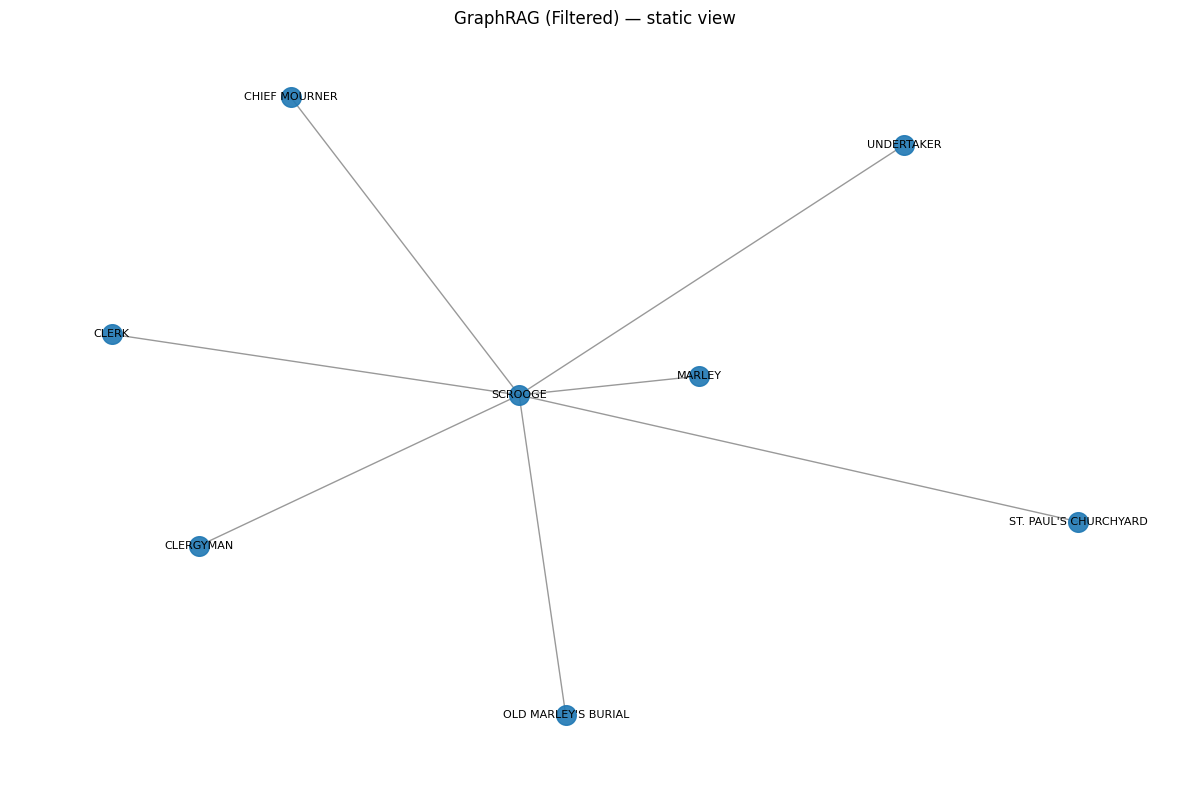

Saved static plot to ./output/_viz/graph_static.png


In [8]:

# --- Prepare a filtered subgraph for quick static plotting ---
H = G.copy()
if TOP_N_NODES is not None and H.number_of_nodes() > TOP_N_NODES:
    degs = sorted(H.degree, key=lambda x: x[1], reverse=True)[:TOP_N_NODES]
    keep = set(n for n,_ in degs)
    H = H.subgraph(keep).copy()

print(f"Using subgraph for plotting: Nodes={H.number_of_nodes()}, Edges={H.number_of_edges()}")

pos = nx.spring_layout(H, seed=SEED, k=None)  # Fruchterman-Reingold
node_labels = {n: H.nodes[n].get("title", str(n)) for n in H.nodes()}

plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(H, pos, node_size=200, alpha=0.9)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=8)
plt.axis("off")
plt.title("GraphRAG (Filtered) — static view")
plt.tight_layout()
plt.savefig(f"{VIZ_DIR}/graph_static.png", dpi=150)
plt.show()

print(f"Saved static plot to {VIZ_DIR}/graph_static.png")


In [13]:
# 目录
VIZ.mkdir(parents=True, exist_ok=True)
html_path = VIZ / "graph_interactive.html"

# ---- PyVis 交互图（稳妥版）----
try:
    from pyvis.network import Network

    net = Network(height="800px", width="100%", notebook=False)
    net.force_atlas_2based()  # 或者 net.barnes_hut()

    # 节点
    for n, d in H.nodes(data=True):
        title = d.get("title", str(n))
        etype = d.get("type", "")
        net.add_node(str(n),
                     label=title,
                     title=f"{title}<br>type={etype}")

    # 边
    for u, v, d in H.edges(data=True):
        net.add_edge(str(u), str(v),
                     title=str(d.get("label", "")),
                     value=float(d.get("weight", 1.0)))

    # 关键：不用 show()，用 write_html（新）或 save_graph（旧）
    try:
        net.write_html(str(html_path), notebook=False, open_browser=False)
    except AttributeError:
        # 兼容旧版 pyvis
        net.save_graph(str(html_path))

    print(f"Saved interactive HTML to {html_path}")

except Exception as e:
    import jinja2
    print("PyVis step failed:", e, "| jinja2 version =", getattr(jinja2, "__version__", "unknown"))


Saved interactive HTML to output\_viz\graph_interactive.html



## Export CSVs for Neo4j bulk import
This creates `nodes.csv` and `edges.csv` under the viz folder. You can then use Neo4j Admin import or APOC to load them.


In [12]:
nodes_csv = VIZ / "nodes.csv"
edges_csv = VIZ / "edges.csv"

nodes_df = pd.DataFrame([
    {"id": n, "name": H.nodes[n].get("title", n), "etype": H.nodes[n].get("type", "Entity")}
    for n in H.nodes()
])
edges_df = pd.DataFrame([
    {"source": u, "target": v, "weight": d.get("weight", 1.0), "label": d.get("label","RELATED")}
    for u, v, d in H.edges(data=True)
])

nodes_df.to_csv(nodes_csv, index=False, encoding="utf-8")
edges_df.to_csv(edges_csv, index=False, encoding="utf-8")
print(f"Exported for Neo4j: {nodes_csv}, {edges_csv}")

Exported for Neo4j: output\_viz\nodes.csv, output\_viz\edges.csv
